In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Flatten, Input, Dense, Lambda, UpSampling1D, Conv1D, MaxPooling1D, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm
import pandas as pd
from keras.callbacks import ModelCheckpoint

# Read Data Set

In [19]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [20]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [21]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [22]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

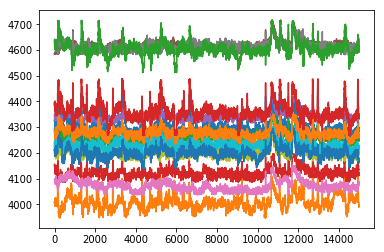

In [23]:
_ = plt.plot(df)

### Normalize Dataset

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

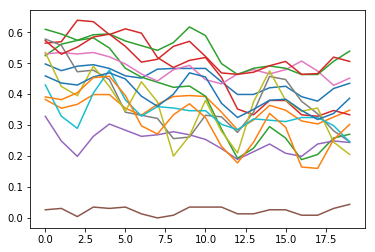

In [25]:
_ = plt.plot(df[:20,:])

array([ 0.56384845,  0.72205709,  0.83781087,  0.87923766,  0.90497573,
        0.92777669,  0.94230164,  0.9558371 ,  0.96768922,  0.97691075,
        0.98448887,  0.99186586,  0.99763554,  1.        ])

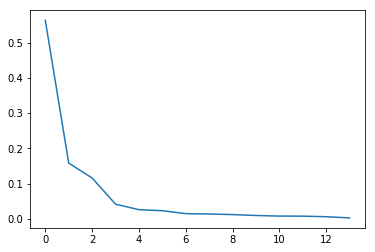

In [26]:
from sklearn import decomposition
pca = decomposition.PCA(df.shape[1])
pca.fit(df)
X_pc = pca.transform(df)
#plt.plot(X_pc)
plt.plot(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

# Conv1D Variational Auto Encoder 

## Sampling

In [27]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

## Loss

In [28]:
def vae_loss(x, x_decoded_mean_squash):
    #x = K.flatten(x)
    #x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = 10*K.mean(metrics.binary_crossentropy(x, x_decoded_mean_squash))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

# Encoder

### Meta Parameters

In [265]:
input_dim = df.shape[1]
timesteps = 8
jump = 2
nb_epoch = 10

validation_split = 0.1
batch_size = 10

conv_1_size = 300
conv_1_kernel_size = 3
conv_1_pool_size = 1

conv_2_size = 150
conv_2_kernel_size = 2
conv_2_pool_size = 1
intermediate_dim = 75
latent_dim = 2

epsilon_std = 0.01

## Generate the time series

In [266]:
indexes = [range(i,i+timesteps) for i in range(0,df.shape[0]-jump-timesteps,jump)]
X = df[indexes]

In [290]:
train_size_proportion = 0.67
train_size = int(len(X) * train_size_proportion)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]

## Encoder

In [291]:
inputs = Input(shape=(timesteps, input_dim))
conv_1 = Conv1D(filters=conv_1_size, 
                kernel_size=conv_1_kernel_size, 
                padding='same', 
                activation='relu')(inputs)
max_pooling_1 = MaxPooling1D(pool_size=conv_1_pool_size)(conv_1)
conv_2 = Conv1D(filters=conv_2_size, 
                kernel_size=conv_2_kernel_size, 
                padding='same', 
                activation='relu')(max_pooling_1)
max_pooling_2 = MaxPooling1D(pool_size=conv_2_pool_size)(conv_2)
flatten       = Flatten()(max_pooling_2)
encoded_hidden = Dense(intermediate_dim,
                       activation='relu')(flatten)
z_mean = Dense(latent_dim)(encoded_hidden)
z_log_sigma = Dense(latent_dim)(encoded_hidden)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [292]:
sequence_encoder = Model(inputs=inputs, outputs=z_mean)
sequence_encoder.compile(optimizer='rmsprop', loss=vae_loss)

## Decoder

In [293]:
decoded_hidden = Dense(intermediate_dim, activation='relu')
decoded_repeated = RepeatVector(timesteps / conv_1_pool_size / conv_2_pool_size)
upsampling_2 = UpSampling1D(size=conv_2_pool_size)
deconv_2 = Conv1D(filters=conv_2_size, 
                  kernel_size=conv_2_kernel_size, 
                  padding='same', 
                  activation='relu')
upsampling_1 = UpSampling1D(size=conv_1_pool_size)
deconv_1 = Conv1D(filters=conv_1_size, 
                  kernel_size=conv_1_kernel_size, 
                  padding='same', 
                  activation='relu')
dense_last = Dense(input_dim)

In [294]:
decoded_inputs_layer = Input(shape = (latent_dim,))
decoded_hidden_layer = decoded_hidden(decoded_inputs_layer)
decoded_repeated_layer = decoded_repeated(decoded_hidden_layer)
decoded_upsampling_2_layer = upsampling_2(decoded_repeated_layer)
decoded_deconv_2_layer = deconv_2(decoded_upsampling_2_layer)
decoded_upsampling_1_layer = upsampling_1(decoded_deconv_2_layer)
decoded_deconv_1_layer = deconv_1(decoded_upsampling_1_layer)
decoded_output_layer = dense_last(decoded_deconv_1_layer)

In [295]:
sequence_decoder = Model(inputs=decoded_inputs_layer,
                         outputs=decoded_output_layer)
sequence_decoder.compile(optimizer='rmsprop', loss=vae_loss)

## Auto Encoder

In [296]:
ae_hidden_layer = decoded_hidden(z)
ae_repeated_layer = decoded_repeated(ae_hidden_layer)
ae_upsampling_2_layer = upsampling_2(ae_repeated_layer)
ae_deconv_2_layer = deconv_2(ae_upsampling_2_layer)
ae_upsampling_1_layer = upsampling_1(ae_deconv_2_layer)
ae_deconv_1_layer = deconv_1(ae_upsampling_1_layer)
ae_output_layer = dense_last(ae_deconv_1_layer)

In [297]:
sequence_autoencoder = Model(inputs, ae_output_layer)
sequence_autoencoder.compile(optimizer='rmsprop', loss=vae_loss)

# Fit 

In [298]:
filepath_loss = "checkpoint/better_loss_.hdf5"
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='auto')
filepath_val_loss = "checkpoint/better_val_loss_epoch-{epoch:02d}.hdf5"   
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      mode='auto')
callbacks_list = [checkpoint_loss,
                  checkpoint_val_loss]
history = sequence_autoencoder.fit(train,
                                   train,
                                   batch_size,
                                   nb_epoch,
                                   callbacks = callbacks_list,
                                   validation_split=validation_split,
                                   verbose = 1,
                                   shuffle = True)

Train on 4512 samples, validate on 502 samples
Epoch 1/10
4512/4512 [==============================] - 5s - loss: 8.2100 - val_loss: 5.7732
Epoch 2/10
4512/4512 [==============================] - 3s - loss: 6.1424 - val_loss: 5.8619
Epoch 3/10
4512/4512 [==============================] - 3s - loss: 6.0908 - val_loss: 5.6993
Epoch 4/10
4512/4512 [==============================] - 3s - loss: 6.0762 - val_loss: 5.6892
Epoch 5/10
4512/4512 [==============================] - 3s - loss: 6.0561 - val_loss: 5.9680
Epoch 6/10
4512/4512 [==============================] - 3s - loss: 6.0494 - val_loss: 5.7006
Epoch 7/10
4512/4512 [==============================] - 3s - loss: 6.0430 - val_loss: 5.6832
Epoch 8/10
4512/4512 [==============================] - 3s - loss: 6.0388 - val_loss: 5.7357
Epoch 9/10
4512/4512 [==============================] - 3s - loss: 6.0371 - val_loss: 5.6949
Epoch 10/10
4512/4512 [==============================] - 3s - loss: 6.0301 - val_loss: 5.6977


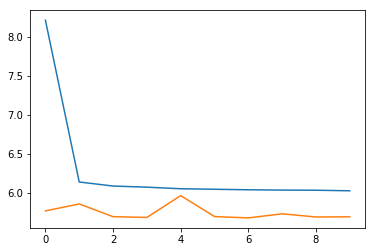

In [299]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Predict

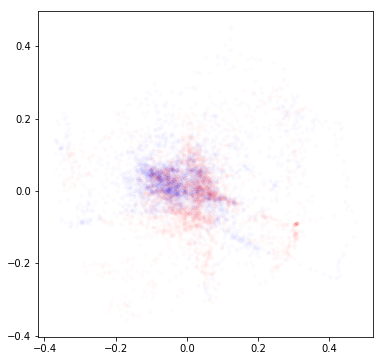

In [300]:
x_test_encoded = sequence_encoder.predict(X, batch_size=batch_size)
colors_map = {1:"red", 0:"Blue"}
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=map(colors_map.__getitem__,y), alpha = 0.01,s = 10)
#plt.colorbar()
plt.show()

# Generate

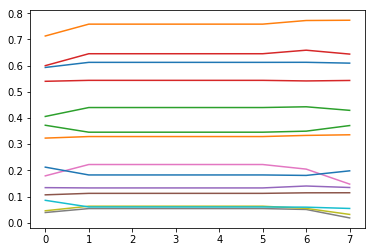

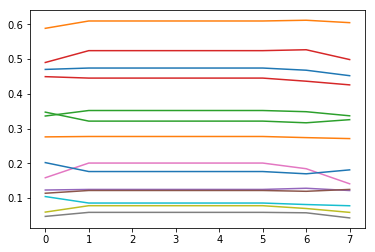

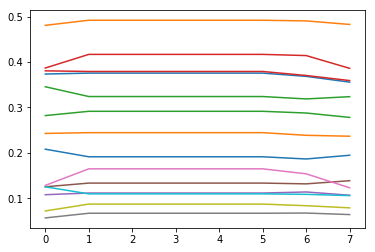

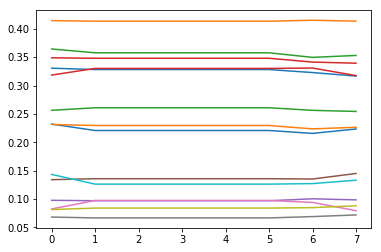

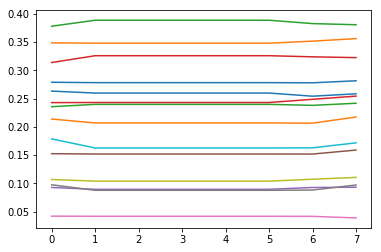

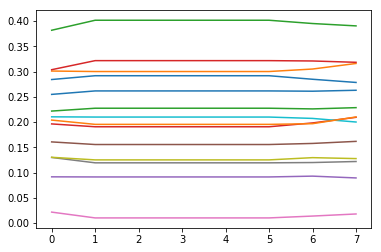

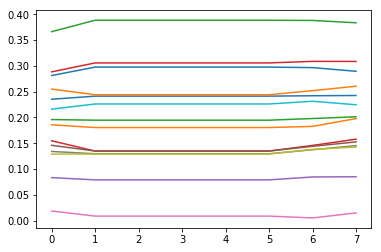

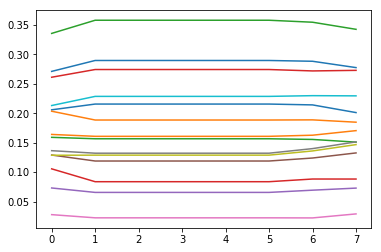

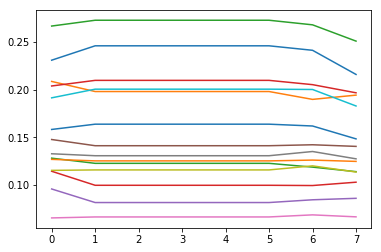

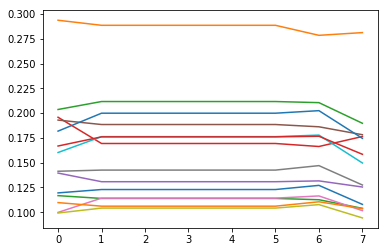

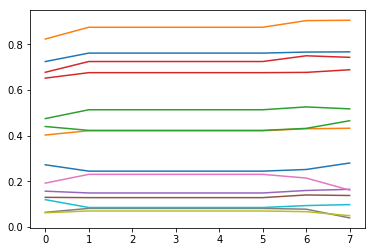

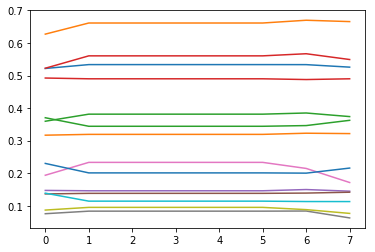

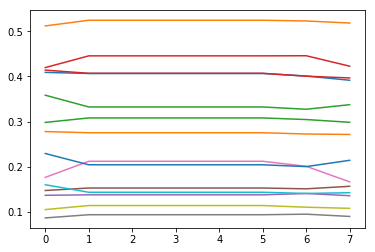

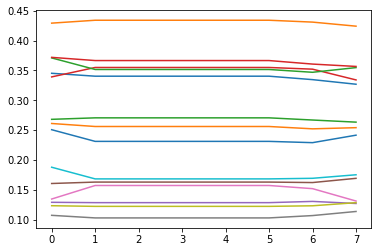

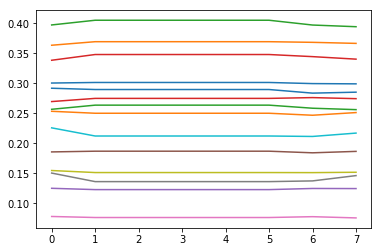

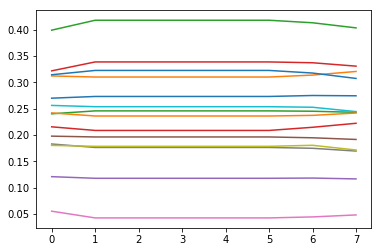

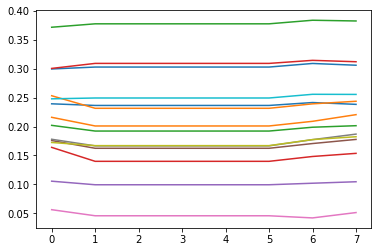

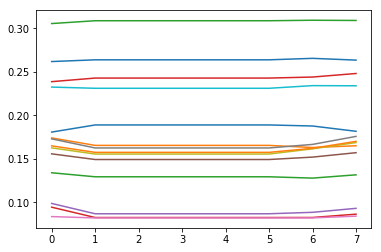

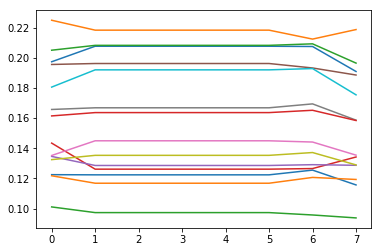

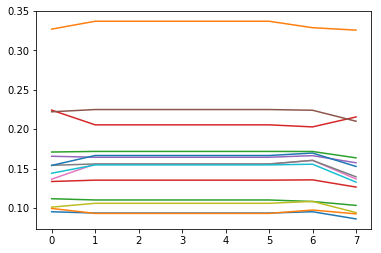

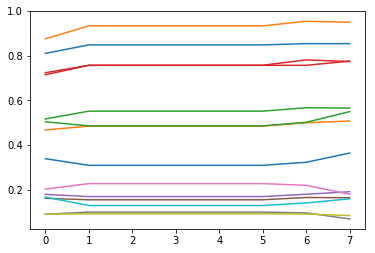

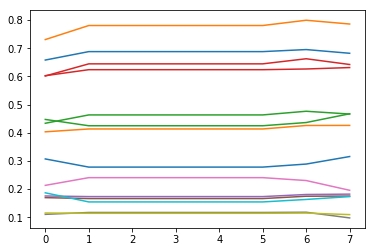

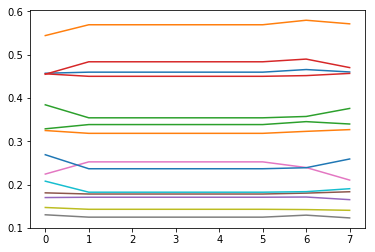

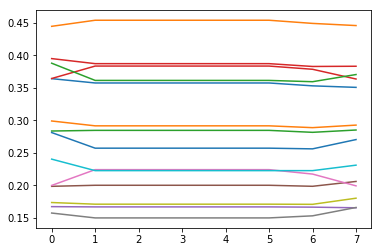

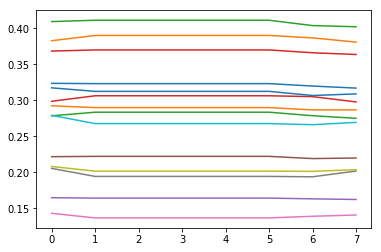

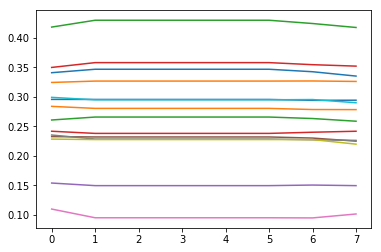

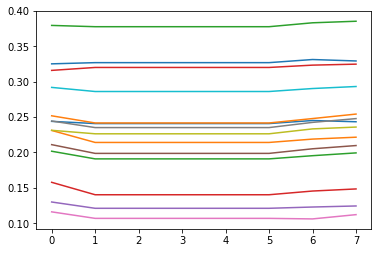

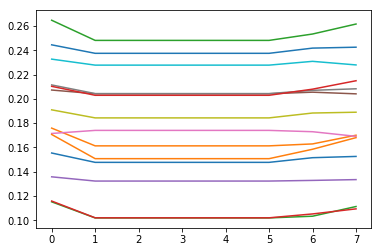

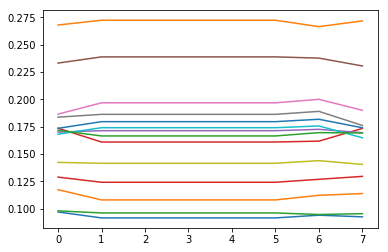

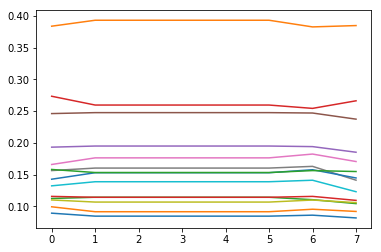

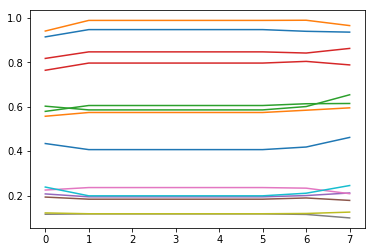

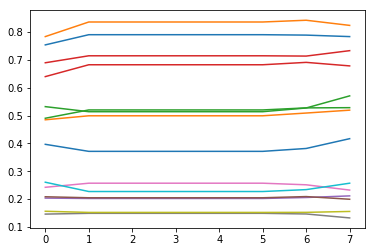

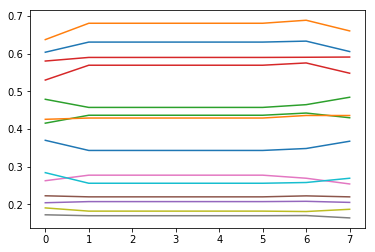

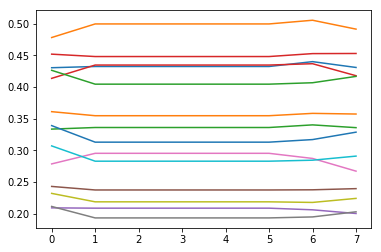

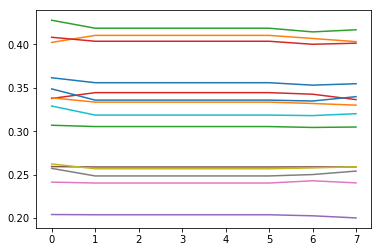

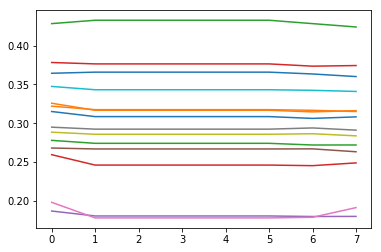

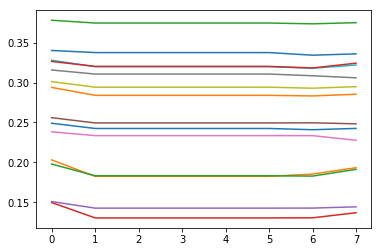

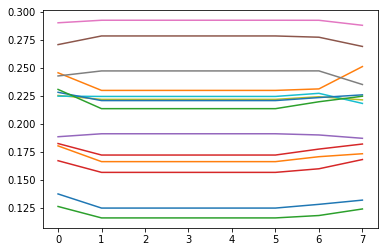

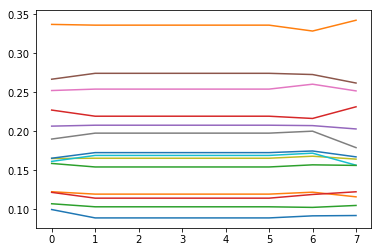

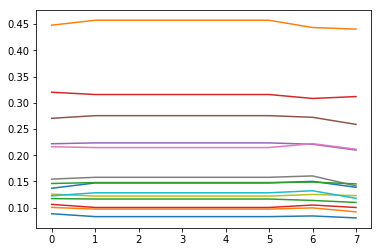

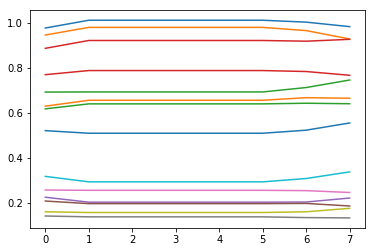

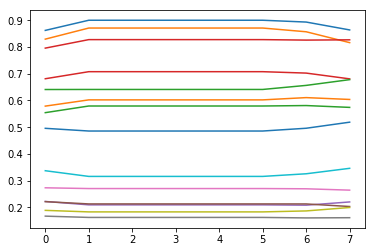

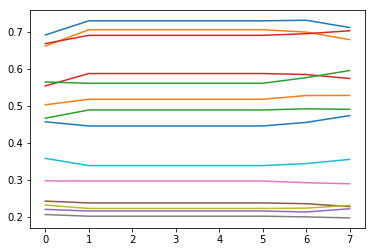

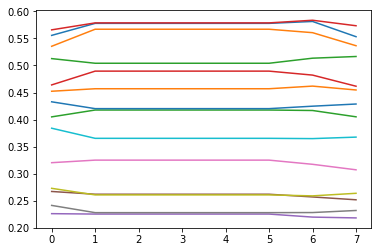

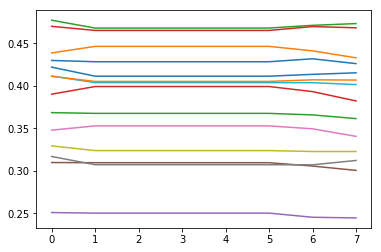

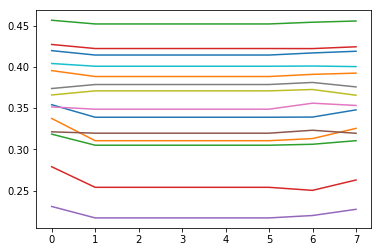

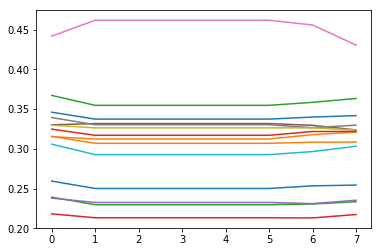

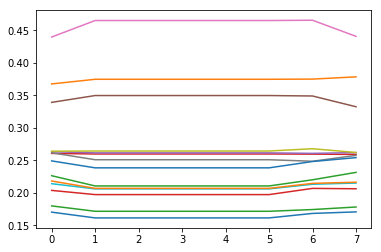

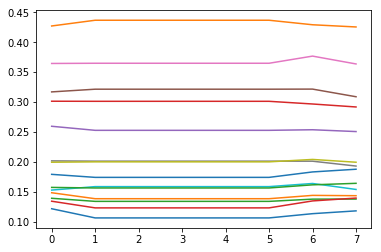

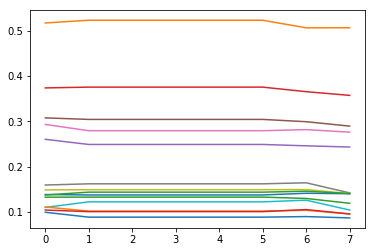

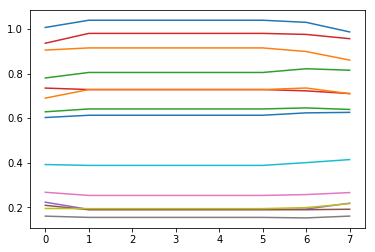

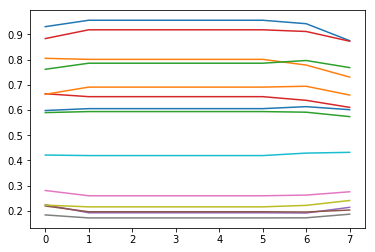

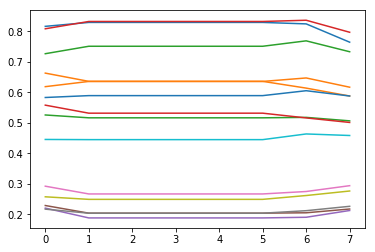

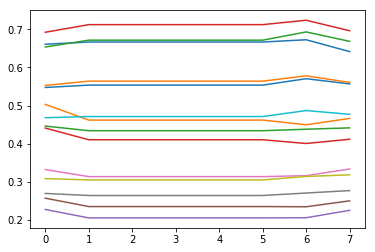

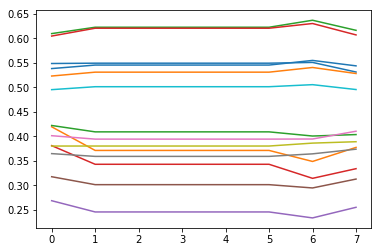

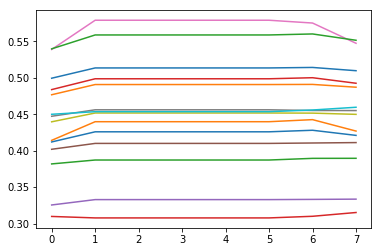

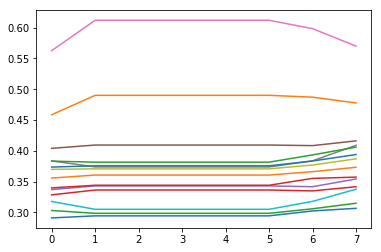

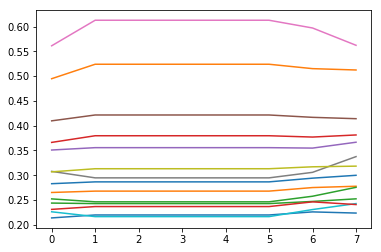

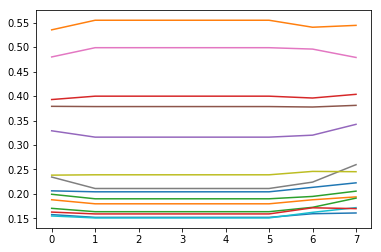

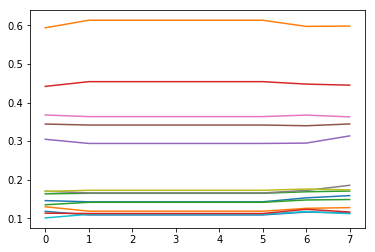

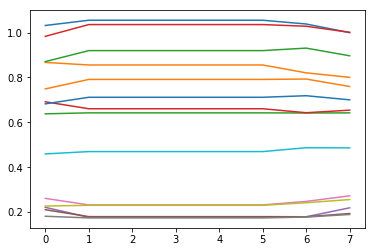

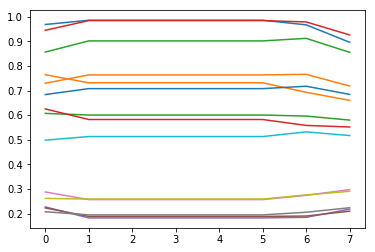

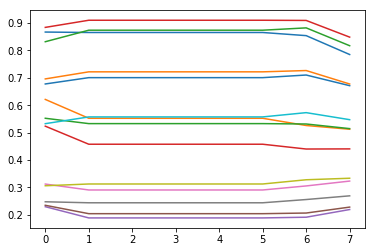

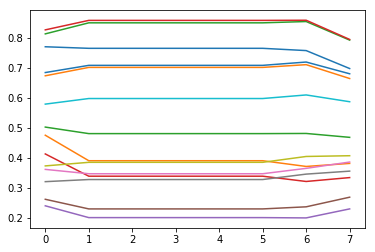

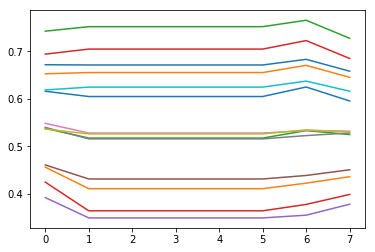

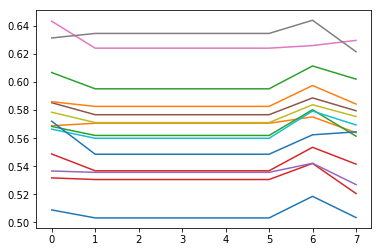

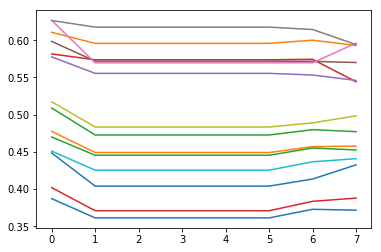

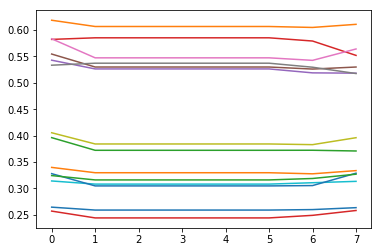

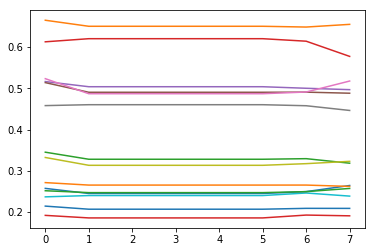

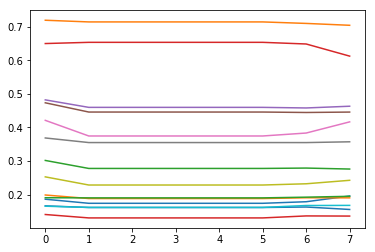

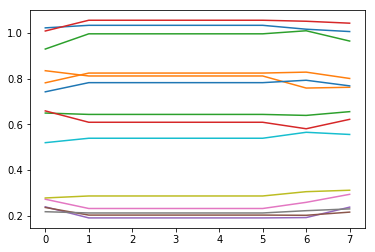

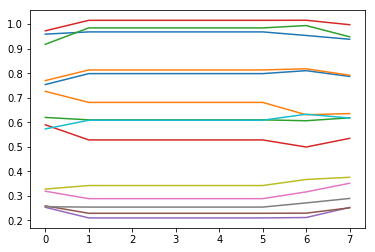

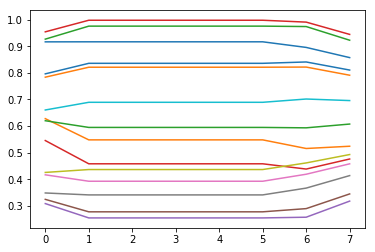

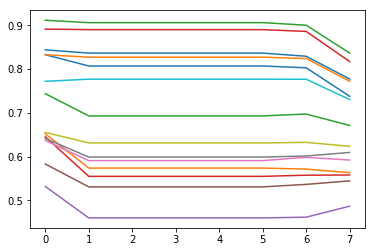

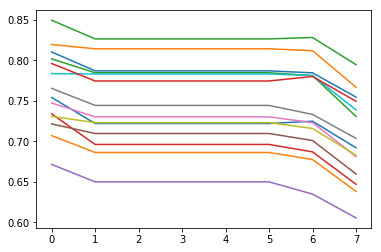

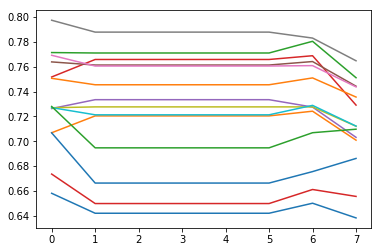

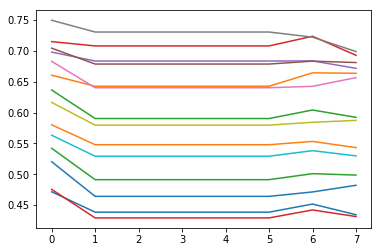

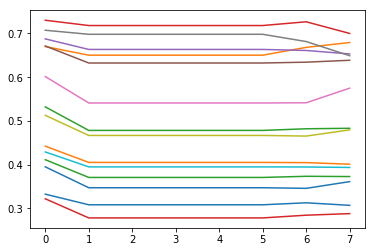

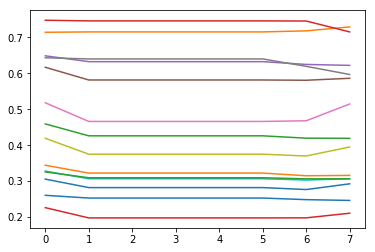

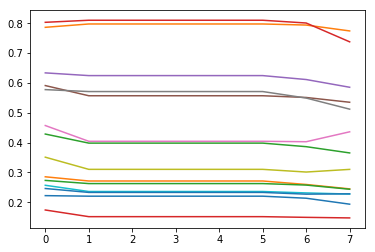

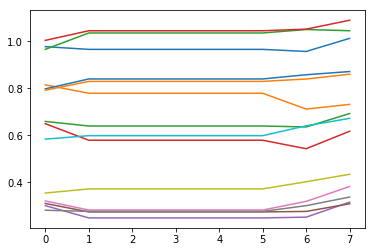

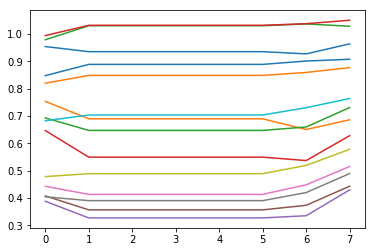

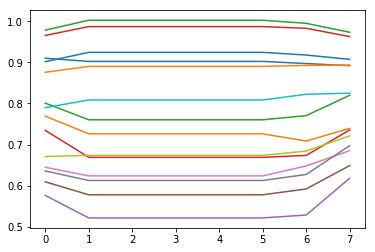

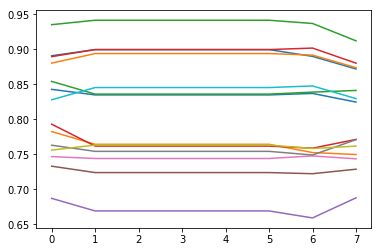

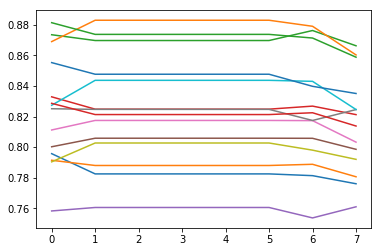

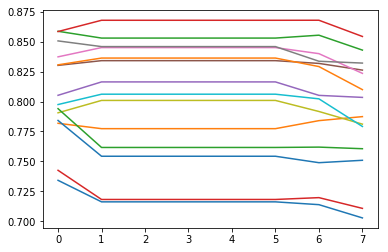

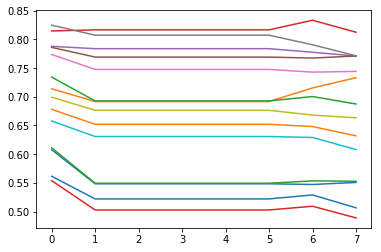

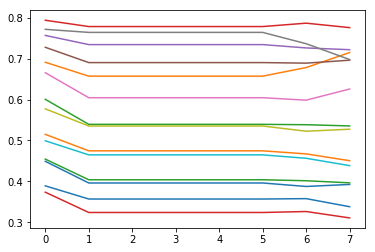

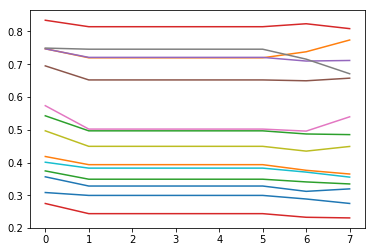

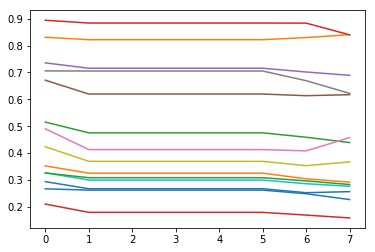

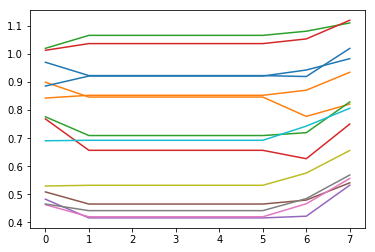

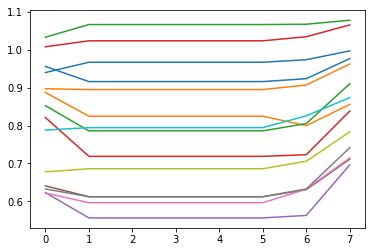

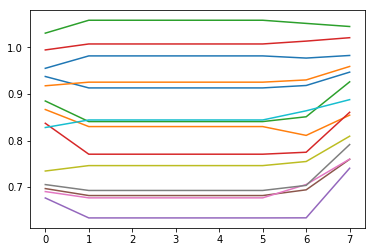

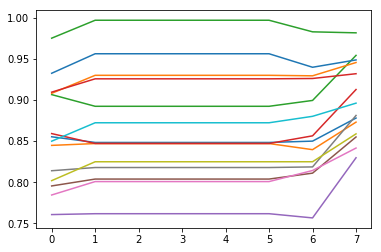

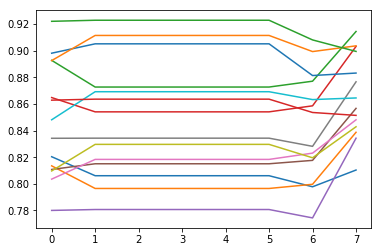

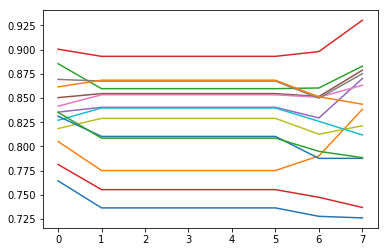

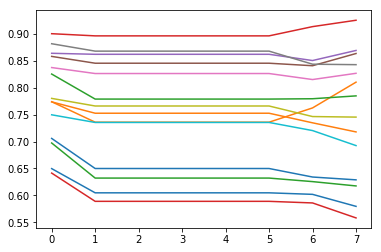

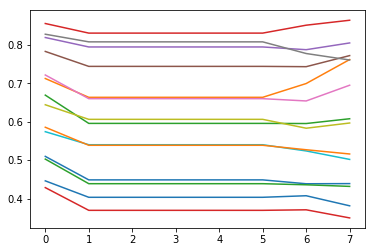

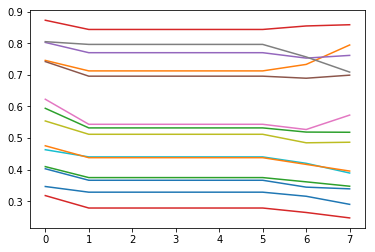

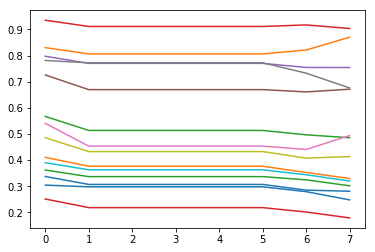

In [278]:
n = 10  # figure with 15x15 digits

grid_x = np.linspace(-0.3, 0.3, n)
grid_y = np.linspace(-0.3, 0.3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])# * epsilon_std
        ts = sequence_decoder.predict(z_sample)
        plt.figure()
        plt.plot(ts[0,:])

# Error

In [310]:
predicted_train = sequence_autoencoder.predict(train)
per_location_error_train = ((predicted_train - train)**2).sum(2).sum(1)
th = np.percentile(per_location_error_train,99.99)

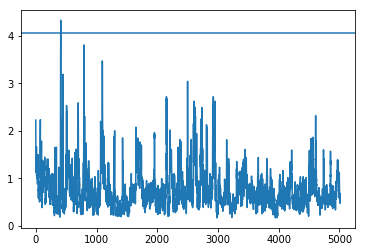

In [311]:
plt.plot(per_location_error_train)
plt.axhline(y=th)

In [312]:
predicted = sequence_autoencoder.predict(test)

In [313]:
per_location_error = ((predicted - test)**2).sum(2).sum(1)

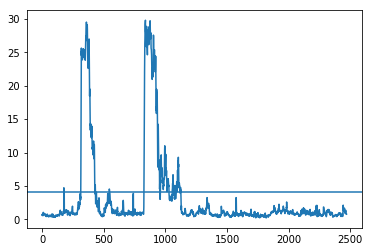

In [314]:
plt.plot(per_location_error)
plt.axhline(y=th)

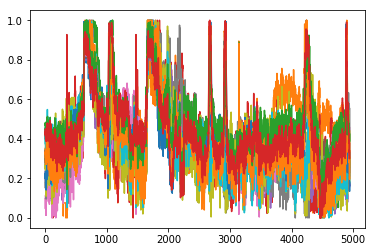

In [306]:
_ = plt.plot(df[int(len(df)*0.67):,:])